# Imports

In [32]:
import os
import sys

# Root path
ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(ROOT)
print(ROOT)

import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
from src.config import CONFIG
from datetime import datetime

# Data paths
RAW_DATA_PATH = CONFIG.RAW_DATA_PATH
PRO_DATA_PATH_v1 = CONFIG.PRO_DATA_PATH_v1

/workspaces/AI-Researcher-Task


# Data load and downcast

In [4]:
# def load_raw_data_save(read_path, save_path):
#     df = pl.read_csv(read_path, try_parse_dates=True)

#     df = df.with_columns([
#         pl.col(col).cast(pl.Float32, strict=False) for col in df.columns if col != "Date Time"
#     ])

#     df.sort("Date Time").write_parquet(save_path)

#     return df

# df = load_raw_data_save(RAW_DATA_PATH, PRO_DATA_PATH_v1)

Reload from saved parquet file

In [5]:
df = pl.read_parquet(PRO_DATA_PATH_v1)

In [6]:
def check_data(df):
    print(f"Data shape: {df.shape}")

    missing_values = df.null_count()
    print("\nMissing values per column:")
    print(missing_values)
    print("\nTotal missing values:") 
    print(missing_values.to_numpy()[0].sum())

    min_date = df["Date Time"].min()
    max_date = df["Date Time"].max()
    print(f"\nDate range: {min_date} to {max_date}")

check_data(df)

Data shape: (420551, 15)

Missing values per column:
shape: (1, 15)
┌───────────┬──────────┬──────────┬──────────┬───┬──────────┬──────────┬────────────────┬──────────┐
│ Date Time ┆ p (mbar) ┆ T (degC) ┆ Tpot (K) ┆ … ┆ rho      ┆ wv (m/s) ┆ max. wv (m/s)  ┆ wd (deg) │
│ ---       ┆ ---      ┆ ---      ┆ ---      ┆   ┆ (g/m**3) ┆ ---      ┆ ---            ┆ ---      │
│ u32       ┆ u32      ┆ u32      ┆ u32      ┆   ┆ ---      ┆ u32      ┆ u32            ┆ u32      │
│           ┆          ┆          ┆          ┆   ┆ u32      ┆          ┆                ┆          │
╞═══════════╪══════════╪══════════╪══════════╪═══╪══════════╪══════════╪════════════════╪══════════╡
│ 0         ┆ 0        ┆ 0        ┆ 0        ┆ … ┆ 0        ┆ 0        ┆ 0              ┆ 0        │
└───────────┴──────────┴──────────┴──────────┴───┴──────────┴──────────┴────────────────┴──────────┘

Total missing values:
0

Date range: 2009-01-01 00:10:00 to 2017-01-01 00:00:00


In [7]:
print(df.to_pandas().describe())

                        Date Time       p (mbar)       T (degC)  \
count                      420551  420551.000000  420551.000000   
mean   2012-12-30 06:26:51.498724     989.212952       9.450148   
min           2009-01-01 00:10:00     913.599976     -23.010000   
25%           2010-12-31 03:25:00     984.200012       3.360000   
50%           2012-12-30 06:20:00     989.580017       9.420000   
75%           2014-12-29 18:55:00     994.719971      15.470000   
max           2017-01-01 00:00:00    1015.349976      37.279999   
std                           NaN       8.358480       8.423365   

            Tpot (K)    Tdew (degC)         rh (%)   VPmax (mbar)  \
count  420551.000000  420551.000000  420551.000000  420551.000000   
mean      283.492737       4.955855      76.008263      13.576251   
min       250.600006     -25.010000      12.950000       0.950000   
25%       277.429993       0.240000      65.209999       7.780000   
50%       283.470001       5.220000      79.300003 

### Correct outliers

In [8]:
# How many negs in to_correct = ['wv (m/s)', 'max. wv (m/s)']

for col in ['wv (m/s)', 'max. wv (m/s)']:
    print(col, df.filter(pl.col(col) < 0).select(col).count().to_numpy()[0])

wv (m/s) [18]
max. wv (m/s) [20]


In [9]:
out_df = df.filter((pl.col("wv (m/s)") < 0) | (pl.col("max. wv (m/s)") < 0))
min_date = out_df["Date Time"].min()
max_date = out_df["Date Time"].max()
print(f"\nDate range: {min_date} to {max_date}")


Date range: 2015-07-13 09:00:00 to 2015-07-13 12:10:00


In [10]:
# Convert to NaN to later impute
df = df.with_columns([
    pl.col("wv (m/s)").replace(-9999, None),
    pl.col("max. wv (m/s)").replace(-9999, None)
])

# Visualize original data

In [ ]:
df_2y = df.filter(pl.col("Date Time").is_between(datetime(2014, 1, 1), datetime(2016, 12, 31)))

In [12]:
def plot_time_series(df: pl.DataFrame):
    # Define grouped variables for plotting
    grouped_variables = [
        ["p (mbar)", "rho (g/m**3)", "Tpot (K)"],
        ["Tdew (degC)", "T (degC)", "max. wv (m/s)", "wv (m/s)"],
        ["VPmax (mbar)", "VPact (mbar)", "VPdef (mbar)", "sh (g/kg)", "H2OC (mmol/mol)", "rh (%)"]
    ]

    # Ensure Date Time column is in datetime format
    if df["Date Time"].dtype != pl.Datetime:
        df = df.with_columns(pl.col("Date Time").str.to_datetime("%Y-%m-%d"))

    # Check if the DataFrame is empty
    if df.is_empty():
        print("No data available to plot.")
        return

    for cols in grouped_variables:
        # Filter only existing columns
        existing_cols = [col for col in cols if col in df.columns]

        if not existing_cols:
            print(f"Skipping plot: None of {cols} exist in the DataFrame.")
            continue  # Skip this group if no columns exist

        plt.figure(figsize=(12, 6))
        for col in existing_cols:
            plt.plot(df["Date Time"].to_pandas(), df[col].to_pandas(), label=col, alpha=0.7)

        plt.xlabel("Date Time")
        plt.ylabel("Value")
        plt.title(f"Time Series Plot for Available Data")
        plt.legend()
        plt.xticks(rotation=45)
        plt.grid()
        plt.show()

In [13]:
# plot_time_series(df_2y)

# Resample and visualize data

In [14]:
def resample_climate(original_df, every='1h'):

    resampled_df = (original_df
                     .group_by_dynamic("Date Time", every=every)
                     .agg(pl.all()
                          .mean()))

    return resampled_df

def describe_resampling(df, label):
    print(f"--- {label} ---")
    print(f"Shape: {df.shape}")
    print(f"Date Range: {df['Date Time'].min()} -> {df['Date Time'].max()}")

    # Calculate mean absolute difference as a proxy for variation
    for col in ["rh (%)", "p (mbar)", "T (degC)"]:
        if col in df.columns:
            mean_diff = df[col].diff().abs().mean()
            print(f"Mean Abs Diff of {col}: {mean_diff:.2f}")
    print("\n")

# Original 10-min data
describe_resampling(df_2y, "Original 10-min Data")

# Resampling and description
df_1h = resample_climate(df_2y, every="1h")
describe_resampling(df_1h, "1-Hour Resampling")

df_3h = resample_climate(df_2y, every="3h")
describe_resampling(df_3h, "3-Hour Resampling")

df_6h = resample_climate(df_2y, every="6h")
describe_resampling(df_6h, "6-Hour Resampling")

df_1d = resample_climate(df_2y, every="1d")
describe_resampling(df_1d, "1-Day Resampling")

--- Original 10-min Data ---
Shape: (157323, 15)
Date Range: 2014-01-01 00:00:00 -> 2016-12-31 00:00:00
Mean Abs Diff of rh (%): 0.76
Mean Abs Diff of p (mbar): 0.07
Mean Abs Diff of T (degC): 0.16


--- 1-Hour Resampling ---
Shape: (26193, 15)
Date Range: 2014-01-01 00:00:00 -> 2016-12-31 00:00:00
Mean Abs Diff of rh (%): 2.91
Mean Abs Diff of p (mbar): 0.31
Mean Abs Diff of T (degC): 0.68


--- 3-Hour Resampling ---
Shape: (8732, 15)
Date Range: 2014-01-01 00:00:00 -> 2016-12-31 00:00:00
Mean Abs Diff of rh (%): 6.99
Mean Abs Diff of p (mbar): 0.83
Mean Abs Diff of T (degC): 1.75


--- 6-Hour Resampling ---
Shape: (4367, 15)
Date Range: 2014-01-01 00:00:00 -> 2016-12-31 00:00:00
Mean Abs Diff of rh (%): 11.44
Mean Abs Diff of p (mbar): 1.48
Mean Abs Diff of T (degC): 2.94


--- 1-Day Resampling ---
Shape: (1094, 15)
Date Range: 2014-01-01 00:00:00 -> 2016-12-31 00:00:00
Mean Abs Diff of rh (%): 6.50
Mean Abs Diff of p (mbar): 3.81
Mean Abs Diff of T (degC): 1.82




Skipping plot: None of ['p (mbar)', 'rho (g/m**3)', 'Tpot (K)'] exist in the DataFrame.


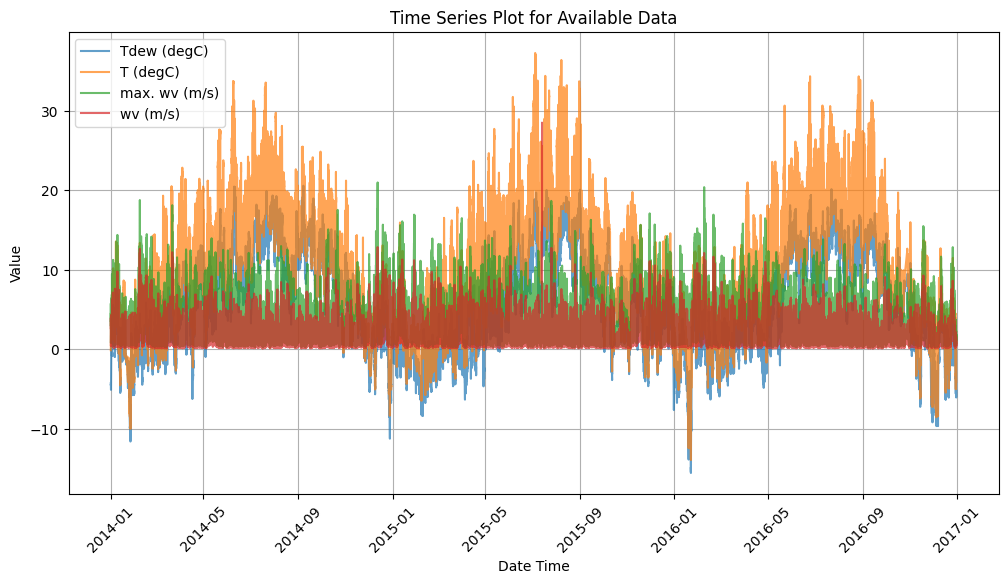

Skipping plot: None of ['VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)', 'H2OC (mmol/mol)', 'rh (%)'] exist in the DataFrame.


In [15]:
vars_to_plot = ["Date Time", "Tdew (degC)", "T (degC)", "max. wv (m/s)", "wv (m/s)"]
plot_time_series(df_2y.select(vars_to_plot))

Skipping plot: None of ['p (mbar)', 'rho (g/m**3)', 'Tpot (K)'] exist in the DataFrame.


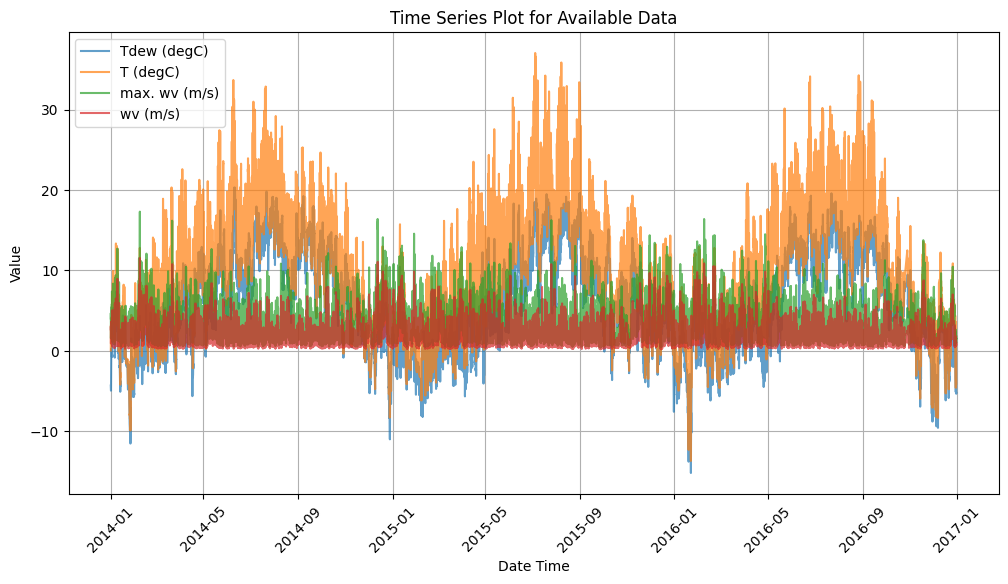

Skipping plot: None of ['VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)', 'H2OC (mmol/mol)', 'rh (%)'] exist in the DataFrame.


In [16]:
vars_to_plot = ["Date Time", "Tdew (degC)", "T (degC)", "max. wv (m/s)", "wv (m/s)"]
plot_time_series(df_1h.select(vars_to_plot))

Skipping plot: None of ['p (mbar)', 'rho (g/m**3)', 'Tpot (K)'] exist in the DataFrame.


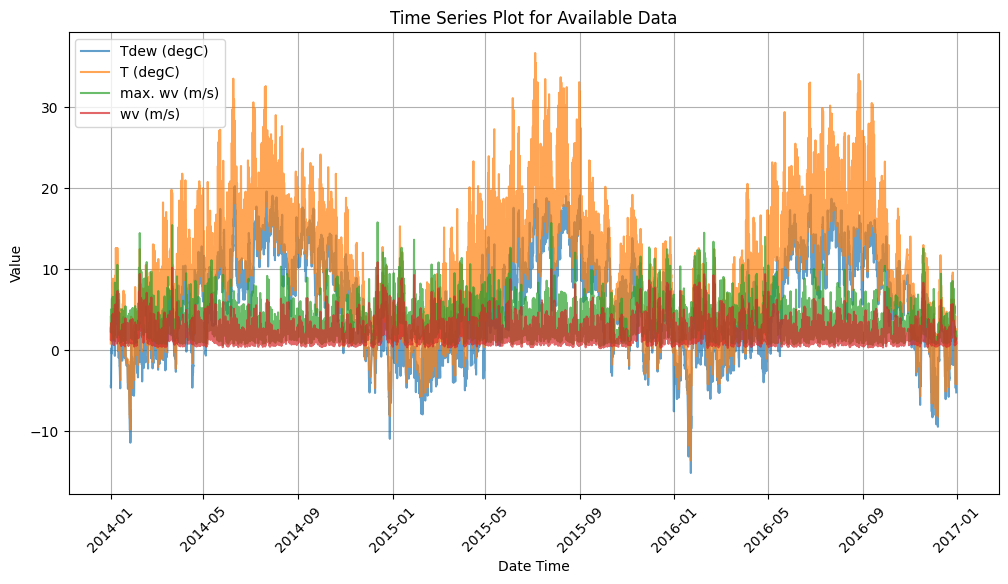

Skipping plot: None of ['VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)', 'H2OC (mmol/mol)', 'rh (%)'] exist in the DataFrame.


In [17]:
plot_time_series(df_3h.select(vars_to_plot))

Skipping plot: None of ['p (mbar)', 'rho (g/m**3)', 'Tpot (K)'] exist in the DataFrame.


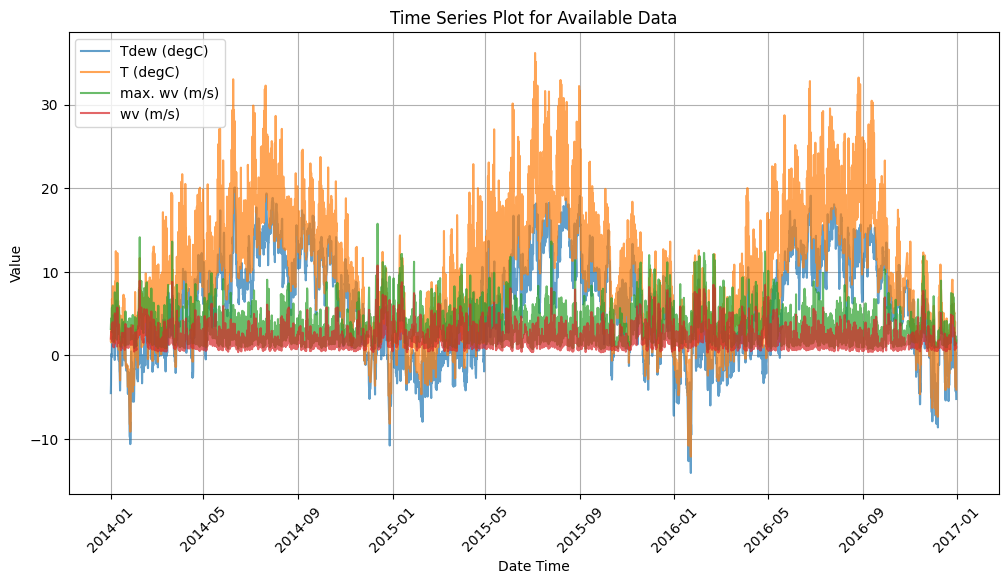

Skipping plot: None of ['VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)', 'H2OC (mmol/mol)', 'rh (%)'] exist in the DataFrame.


In [18]:
plot_time_series(df_6h.select(vars_to_plot))

Skipping plot: None of ['p (mbar)', 'rho (g/m**3)', 'Tpot (K)'] exist in the DataFrame.


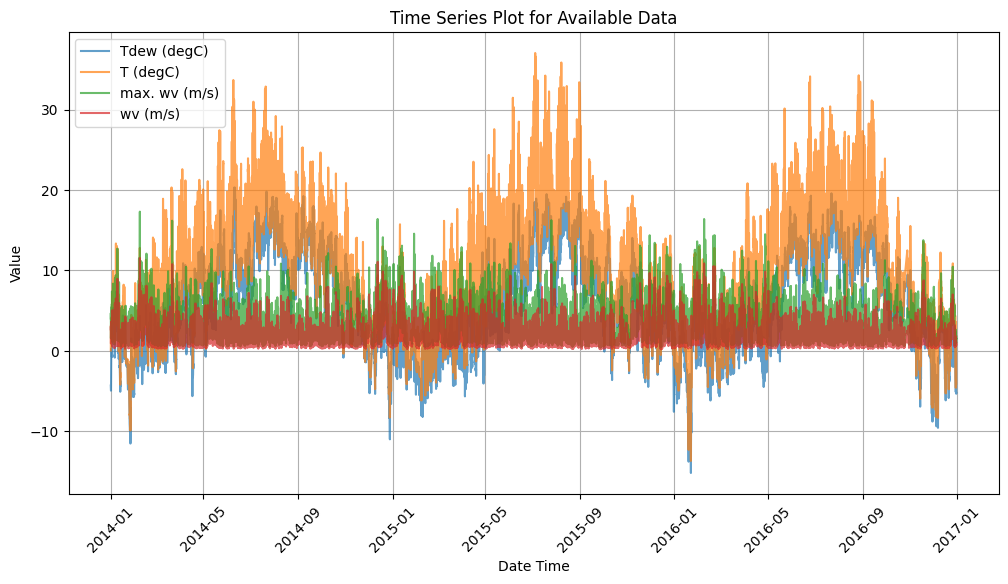

Skipping plot: None of ['VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)', 'H2OC (mmol/mol)', 'rh (%)'] exist in the DataFrame.


In [19]:
plot_time_series(df_1h.select(vars_to_plot))

# 1 month

Skipping plot: None of ['p (mbar)', 'rho (g/m**3)', 'Tpot (K)'] exist in the DataFrame.


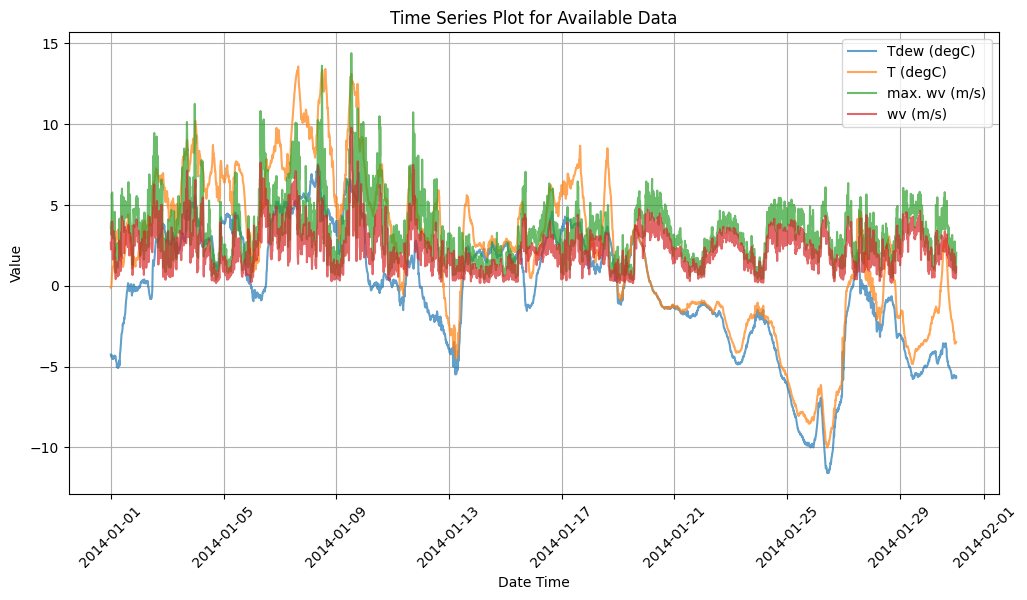

Skipping plot: None of ['VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)', 'H2OC (mmol/mol)', 'rh (%)'] exist in the DataFrame.


In [20]:
df_1m = df_2y.filter(pl.col("Date Time").is_between(datetime(2014, 1, 1), datetime(2014, 1, 31)))
plot_time_series(df_1m.select(vars_to_plot))

Skipping plot: None of ['p (mbar)', 'rho (g/m**3)', 'Tpot (K)'] exist in the DataFrame.


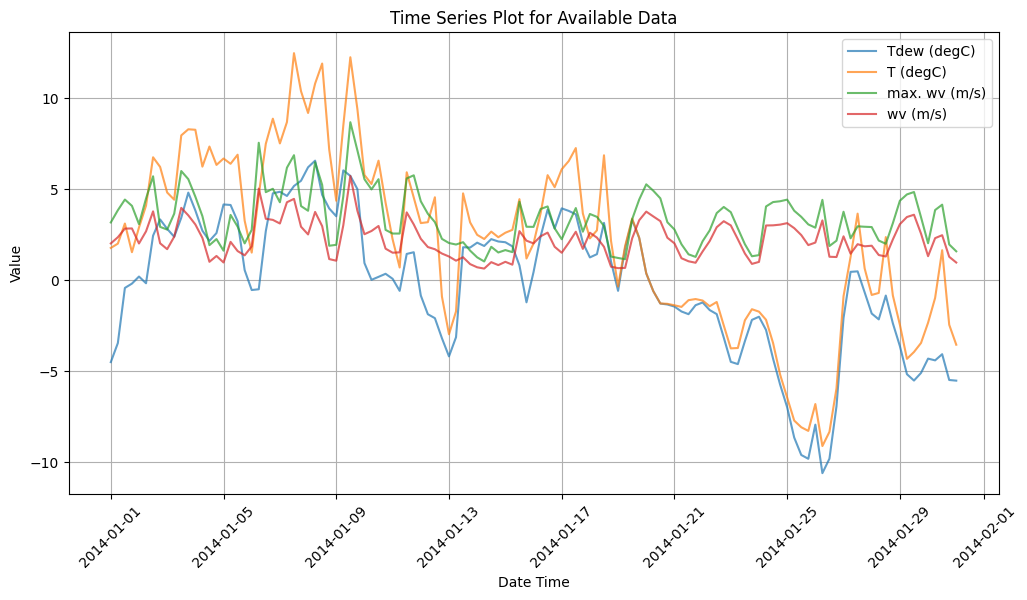

Skipping plot: None of ['VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)', 'H2OC (mmol/mol)', 'rh (%)'] exist in the DataFrame.


In [21]:
df_1m_6h = df_6h.filter(pl.col("Date Time").is_between(datetime(2014, 1, 1), datetime(2014, 1, 31)))
plot_time_series(df_1m_6h.select(vars_to_plot))

# Correlations

In [40]:
df_6h = resample_climate(df, every='6h')

# Compute correlation matrix
correlation_matrix = df_6h.drop("Date Time").corr().to_pandas().round(4)
correlation_matrix.index = correlation_matrix.columns

<Figure size 1200x800 with 0 Axes>

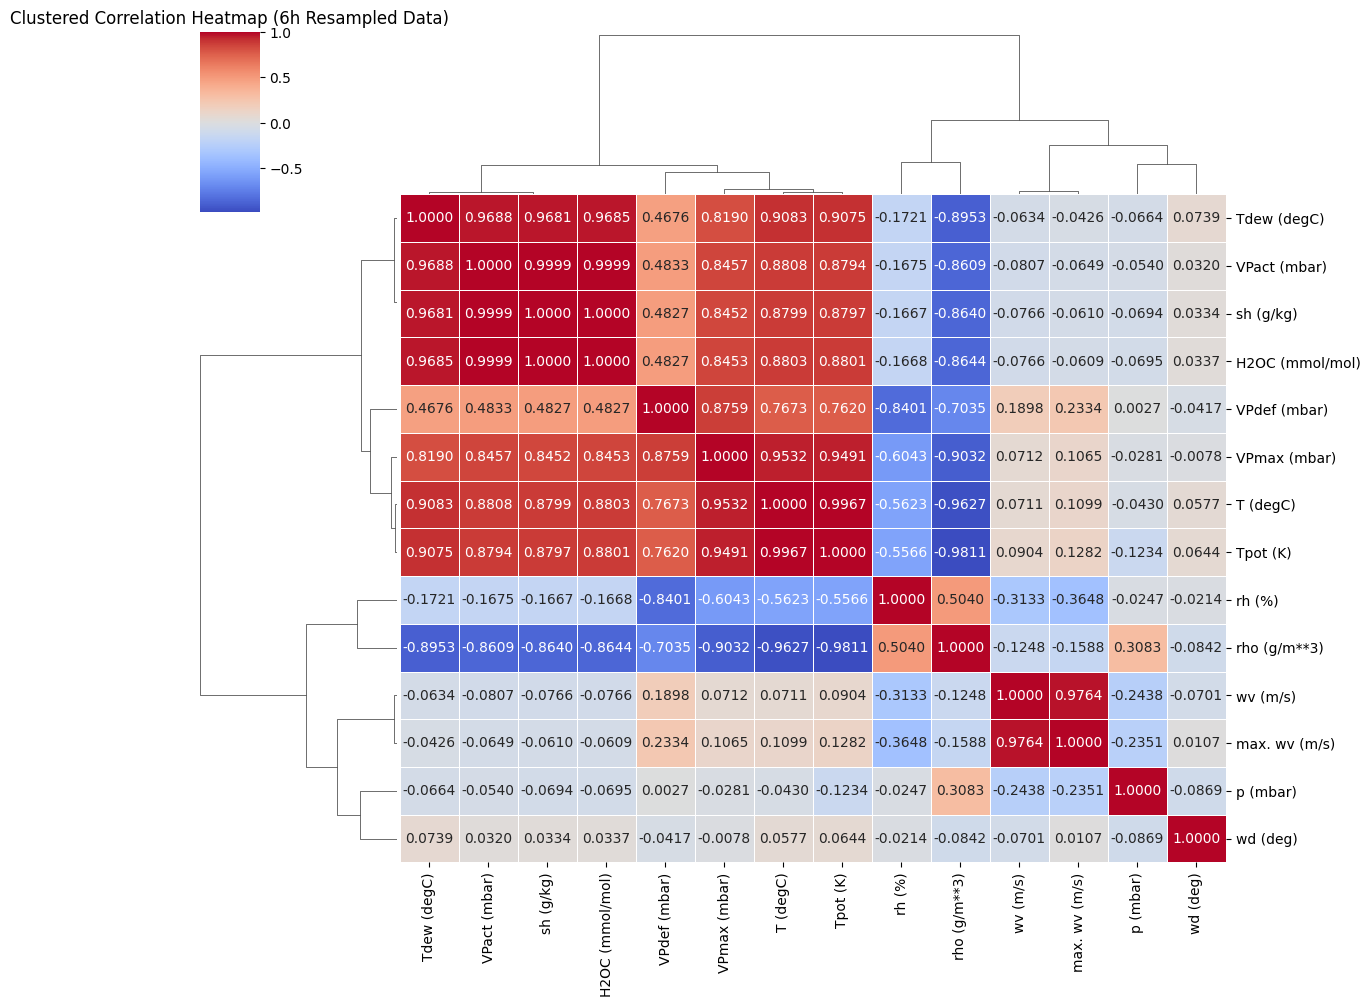

In [41]:
# Create clustered heatmap
plt.figure(figsize=(12, 8))
sns.clustermap(
    correlation_matrix, 
    annot=True, 
    cmap="coolwarm", 
    fmt=".4f", 
    linewidths=0.5, 
    method="ward",  # Clustering method (can be 'average', 'single', 'complete', etc.)
    metric="euclidean",  # Distance metric for clustering
    figsize=(12, 10),
)

plt.title("Clustered Correlation Heatmap (6h Resampled Data)")
plt.show()